In [5]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

In [7]:
data = pd.read_csv('../data/sales_train.csv')
data.date = pd.to_datetime(data.date, format=('%d.%m.%Y'))
display(data.tail())
data.info()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,2015-10-10,33,25,7409,299.0,1.0
2935845,2015-10-09,33,25,7460,299.0,1.0
2935846,2015-10-14,33,25,7459,349.0,1.0
2935847,2015-10-22,33,25,7440,299.0,1.0
2935848,2015-10-03,33,25,7460,299.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [9]:
# 日毎の売上数の合計値に変換
data_by_day = data.groupby(pd.Grouper(key='date', freq='D')).sum().item_cnt_day
data_by_day

date
2013-01-01    1951.0
2013-01-02    8198.0
2013-01-03    7422.0
2013-01-04    6617.0
2013-01-05    6346.0
               ...  
2015-10-27    1551.0
2015-10-28    3593.0
2015-10-29    1589.0
2015-10-30    2274.0
2015-10-31    3104.0
Freq: D, Name: item_cnt_day, Length: 1034, dtype: float64

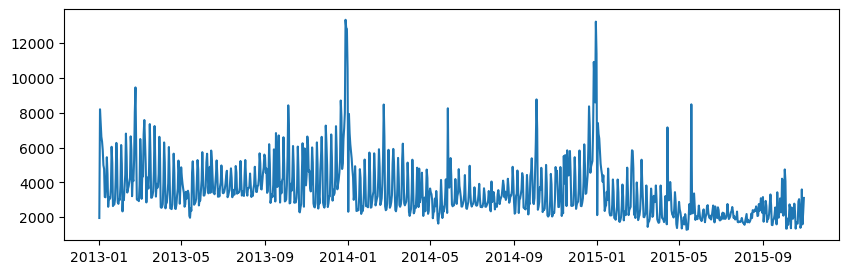

In [10]:
plt.figure(figsize=(10,3))
plt.plot(data_by_day)

### 過去7日間から次の日の売上数を予測するためのデータセットを作成

In [77]:
def making_dataset(
            ds: pd.Series,
            span=7,
            train_rate=0.9)-> list[tuple[np.ndarray, np.ndarray]]:
    data = ds.copy()
    endpoint = len(data) - span
    # [(入力データ, 正解データ)...]
    data = [(data[i: i+span].values, data[i+span]) for i in range(0, endpoint, span)]
    # 訓練データと検証データで分割
    length = len(data)
    train_data = data[0:int(length * train_rate)]
    test_data = data[int(length * train_rate):]

    return train_data, test_data

In [78]:
train_data, test_data = making_dataset(data_by_day)
train_data

[(array([1951., 8198., 7422., 6617., 6346., 5858., 4984.]), 4772.0),
 (array([4772., 3162., 3142., 3829., 5443., 4475., 2595.]), 3137.0),
 (array([3137., 3033., 3096., 3682., 6044., 5111., 2636.]), 2775.0),
 (array([2775., 2727., 3016., 4244., 6267., 5273., 2852.]), 2764.0),
 (array([2764., 3042., 2986., 3817., 6145., 5068., 2330.]), 3302.0),
 (array([3302., 2974., 3760., 4430., 6802., 5511., 3414.]), 3622.0),
 (array([3622., 3780., 4024., 4267., 6643., 5865., 3203.]), 4228.0),
 (array([4228., 4074., 5292., 8009., 9456., 6139., 3024.]), 2978.0),
 (array([2978., 3014., 2919., 3846., 6491., 5476., 3053.]), 4427.0),
 (array([4427., 4337., 6766., 7582., 6385., 5073., 2846.]), 4288.0),
 (array([4288., 4001., 3641., 4890., 7347., 5617., 3113.]), 3122.0),
 (array([3122., 3253., 3484., 4645., 7236., 5221., 3181.]), 3914.0),
 (array([3914., 3673., 3776., 4472., 6617., 5369., 2574.]), 2536.0),
 (array([2536., 2579., 2748., 4010., 6293., 5130., 2506.]), 2779.0),
 (array([2779., 2835., 3315., 3947

In [79]:
test_data

[(array([1952., 2049., 2275., 2359., 2581., 2334., 1954.]), 2045.0),
 (array([2045., 1872., 1872., 1897., 2320., 1722., 1705.]), 1744.0),
 (array([1744., 1752., 1720., 1796., 1953., 1771., 1659.]), 1642.0),
 (array([1642., 1560., 1764., 1972., 2179., 1702., 1854.]), 1731.0),
 (array([1731., 1696., 1765., 1885., 2201., 1948., 2402.]), 2340.0),
 (array([2340., 2305., 2429., 2361., 2620., 2453., 2063.]), 2090.0),
 (array([2090., 2752., 2363., 2564., 3086., 2719., 2250.]), 3154.0),
 (array([3154., 1738., 2193., 2232., 2933., 2638., 1723.]), 1935.0),
 (array([1935., 1919., 2176., 2700., 3304., 2660., 1551.]), 1540.0),
 (array([1540., 1844., 1887., 2118., 2556., 2236., 1586.]), 3428.0),
 (array([3428., 2064., 1966., 2317., 3075., 2818., 2275.]), 4209.0),
 (array([4209., 4068., 2085., 3265., 4742., 4069., 1340.]), 1343.0),
 (array([1343., 1914., 1561., 1922., 2732., 2454., 1363.]), 2556.0),
 (array([2556., 2294., 1908., 2143., 2775., 2330., 1341.]), 1711.0),
 (array([1711., 1647., 1632., 2901

What's up brother ?